# Dataset Overview

* **Data source:** Dataset from London, part of the **Low Carbon London** project by the UK Electricity Network.
* **Time range:** From **11/2011 to 02/2014**.
* **Subjects:** **5,567 households** in London participated in the project.
* **Main data type:** **Electricity consumption** recorded by **smart meters**.
* **Additional data:**

  * **Weather information** in London (temperature, humidity, etc.) to support analysis and consumption forecasting.
  * **UK holiday information** to consider the impact of holidays on electricity demand.
* **Purpose of the dataset:** **Forecast household electricity consumption** as a **time series**.
* **Reference link:** [Kaggle - Energy Consumption Forecast](https://www.kaggle.com/code/maichibao/energy-consumption-forecast)


# Import and Load dataset

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import os

import seaborn as sns

from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

import math
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

import IPython
import IPython.display

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
# sklearn config
from sklearn import set_config
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_squared_error

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jeanmidev/smart-meters-in-london")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/jeanmidev/smart-meters-in-london/versions/21


In [3]:
# Combining all blocks
for num in range(0,112):
    df = pd.read_csv(f"{path}/daily_dataset/daily_dataset/block_"+str(num)+".csv")
    df = df[['day','LCLid','energy_sum']]
    df.reset_index()
    df.to_csv("hc_"+str(num)+".csv")

fout= open("energy.csv","a")
# first file:
for line in open("hc_0.csv"):
    fout.write(line)
# now the rest:
for num in range(0,112):
    f = open("hc_"+str(num)+".csv")
    f.readline() # skip the header
    for line in f:
         fout.write(line)
    f.close()
fout.close()

# EDA

## Energy at Day Level

Here we only get data from 11/2011 to 2/2014.

In [4]:
energy = pd.read_csv('energy.csv').iloc[:2_000_000]
len(energy)

/tmp/ipython-input-2838854618.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  energy = pd.read_csv('energy.csv').iloc[:2_000_000]


2000000

In [5]:
energy['day'] = pd.to_datetime(energy['day'])
energy['energy_sum'] = energy['energy_sum'].astype("float")

In [6]:
energy.head()

,Unnamed: 0,day,LCLid,energy_sum
0,0.0,2012-10-12,MAC000002,7.098
1,1.0,2012-10-13,MAC000002,11.087
2,2.0,2012-10-14,MAC000002,13.223
3,3.0,2012-10-15,MAC000002,10.257
4,4.0,2012-10-16,MAC000002,9.769


In [7]:
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   Unnamed: 0  float64       
 1   day         datetime64[ns]
 2   LCLid       object        
 3   energy_sum  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 61.0+ MB


In [8]:
energy.describe()

,Unnamed: 0,day,energy_sum
count,2.000000e+06,2000000,1.999983e+06
mean,1.599894e+04,2013-03-22 12:56:53.275200256,1.102608e+01
min,0.000000e+00,2011-11-23 00:00:00,0.000000e+00
25%,7.936000e+03,2012-10-13 00:00:00,4.808000e+00
50%,1.588200e+04,2013-03-24 00:00:00,8.144000e+00
75%,2.394600e+04,2013-09-07 00:00:00,1.359100e+01
max,3.616700e+04,2014-02-28 00:00:00,3.325560e+02
std,9.338254e+03,NaN,1.060919e+01



* **Data size and structure:** The dataset contains **2,000,000 records** with 4 columns: `Unnamed: 0`, `day` (datetime), `LCLid` (object), and `energy_sum` (float64). The dataset is large enough for time series analysis while remaining manageable on a personal computer.

* **Time range:** The first date is **23/11/2011** and the last date is **28/02/2014**, covering a period of more than **two years**, suitable for analyzing electricity consumption trends and seasonal variations.

* **Electricity consumption statistics (`energy_sum`):**

  * **Minimum = 0**, **Maximum ≈ 332.556 kWh**, **Mean ≈ 11.03 kWh**
  * **Median ≈ 8.14 kWh**, showing a **right-skewed distribution** with some high-consumption outliers.

* **Data distribution by percentiles:**

  * 25% of households consume ≤ 4.81 kWh, 75% ≤ 13.59 kWh → most households have **moderate energy usage**.



## Sum energy for each day

We sum energy for each day and count of unique houses for each day

In [9]:
energy = energy.groupby('day').agg({
    'energy_sum': 'sum',  # Sum of energy for each day
    'LCLid': 'nunique'    # Count of unique houses for each day
}).reset_index()
energy.head()

,day,energy_sum,LCLid
0,2011-11-23,78.968000,11
1,2011-11-24,177.228000,20
2,2011-11-25,246.590000,25
3,2011-11-26,357.634000,33
4,2011-11-27,361.435001,33


In [10]:
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   day         829 non-null    datetime64[ns]
 1   energy_sum  829 non-null    float64       
 2   LCLid       829 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 19.6 KB


After grouping our data has only 829 rows

## House Count on each day

In the dataset, the number of households with energy data varies across different days. This is likely due to the gradual adoption of smart meters in London. This variation can lead to **misinterpretation**, where energy consumption on a specific day may appear high simply because data was collected from more households.


In [11]:
housecount = energy[['day','LCLid']].set_index('day')
housecount.head(4)

,LCLid
day,
2011-11-23,11
2011-11-24,20
2011-11-25,25
2011-11-26,33


<Axes: xlabel='day'>

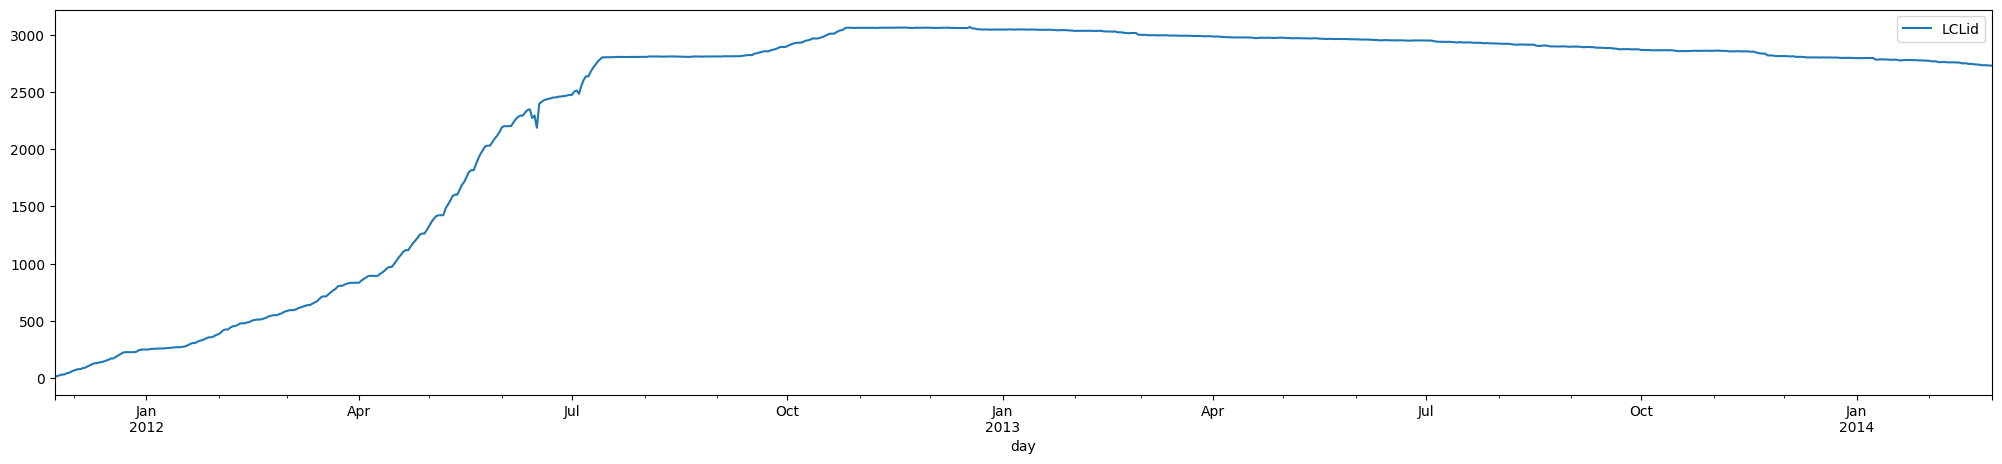

In [12]:
housecount.plot(figsize=(25,5))

We cen see that the house count increase through time from 0 houses to around 2700 houses


## Extract Average Energy Sum per day

Since the number of households varies, leading to different total energy consumption, we aim to **predict the average energy consumption per household**.


In [13]:
energy.head()

,day,energy_sum,LCLid
0,2011-11-23,78.968000,11
1,2011-11-24,177.228000,20
2,2011-11-25,246.590000,25
3,2011-11-26,357.634000,33
4,2011-11-27,361.435001,33


In [14]:
energy.day = pd.to_datetime(energy.day,format='%Y-%m-%d').dt.date

In [15]:
energy['avg_energy'] =  energy['energy_sum']/energy['LCLid']
print("Starting Point of Data at Day Level",min(energy.day))
print("Ending Point of Data at Day Level",max(energy.day))

Starting Point of Data at Day Level 2011-11-23
Ending Point of Data at Day Level 2014-02-28


In [16]:
energy.describe()

,energy_sum,LCLid,avg_energy
count,829.000000,829.000000,829.000000
mean,26600.683627,2381.696019,11.314435
std,12275.674788,963.736791,2.129375
min,78.968000,11.000000,0.233748
25%,21746.422999,2396.000000,9.284042
50%,27854.353999,2854.000000,11.226498
75%,36294.090004,2968.000000,13.014063
max,51926.302998,3066.000000,17.069791


In [17]:
energy.head()

,day,energy_sum,LCLid,avg_energy
0,2011-11-23,78.968000,11,7.178909
1,2011-11-24,177.228000,20,8.861400
2,2011-11-25,246.590000,25,9.863600
3,2011-11-26,357.634000,33,10.837394
4,2011-11-27,361.435001,33,10.952576


## Average energy sum by Year, Month, Day

Next, we visualized how the average energy consumption changes:

- By Year – to observe long-term trends and possible growth or decline in usage.

- By Month – to identify seasonal patterns, such as higher energy consumption during winter months.

- By Weekday – to capture behavioral differences between weekdays and weekends.

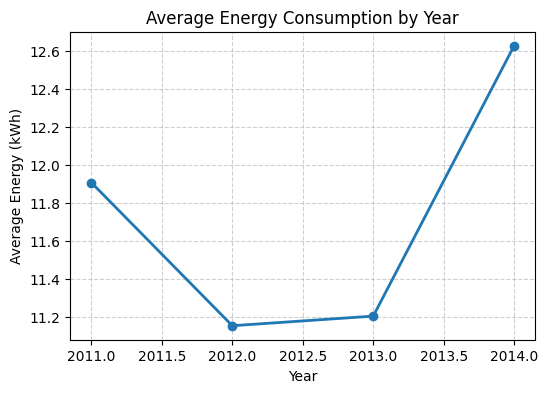

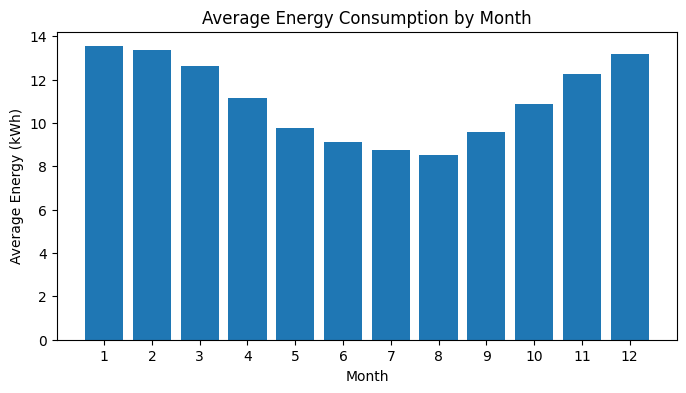

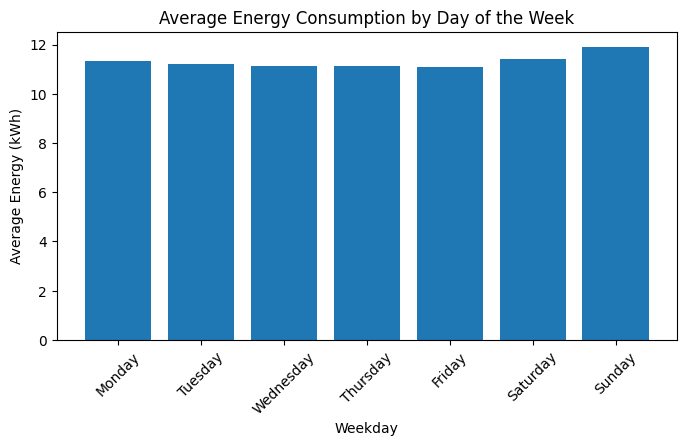

📆 Data Summary:
Starting date: 2011-11-23
Ending date: 2014-02-28

📊 Observations:
- Average yearly consumption ranges from 11.15 to 12.63 kWh.


In [18]:
# Ensure 'day' is datetime
energy['day'] = pd.to_datetime(energy['day'])

# Create year, month, weekday columns
energy['year'] = energy['day'].dt.year
energy['month'] = energy['day'].dt.month
energy['weekday'] = energy['day'].dt.day_name()

# Average energy by year
avg_by_year = energy.groupby('year')['avg_energy'].mean()

plt.figure(figsize=(6,4))
plt.plot(avg_by_year.index, avg_by_year.values, marker='o', linestyle='-', linewidth=2)
plt.title("Average Energy Consumption by Year")
plt.xlabel("Year")
plt.ylabel("Average Energy (kWh)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Average energy by month
avg_by_month = energy.groupby('month')['avg_energy'].mean()
plt.figure(figsize=(8,4))
plt.bar(avg_by_month.index, avg_by_month.values)
plt.title("Average Energy Consumption by Month")
plt.xlabel("Month")
plt.ylabel("Average Energy (kWh)")
plt.xticks(range(1,13))
plt.show()

# Average energy by weekday
avg_by_weekday = energy.groupby('weekday')['avg_energy'].mean()
# Reorder weekdays for clarity
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
avg_by_weekday = avg_by_weekday.reindex(weekday_order)
plt.figure(figsize=(8,4))
plt.bar(avg_by_weekday.index, avg_by_weekday.values)
plt.title("Average Energy Consumption by Day of the Week")
plt.xlabel("Weekday")
plt.ylabel("Average Energy (kWh)")
plt.xticks(rotation=45)
plt.show()

print("📆 Data Summary:")
print(f"Starting date: {energy['day'].min().date()}")
print(f"Ending date: {energy['day'].max().date()}\n")

print("📊 Observations:")
print(f"- Average yearly consumption ranges from {avg_by_year.min():.2f} to {avg_by_year.max():.2f} kWh.")




- Average yearly consumption ranges from 11.15 to 12.63 kWh.
- Monthly averages show possible peaks in winter months (from December–February).
- Weekday trends show higher consumption on weekends (Sat and Sun).

## Weather Information
Daily weather info crawled by darksky api

In [19]:
weather = pd.read_csv(f'{path}/weather_daily_darksky.csv')
weather.head(4)

,temperatureMax,temperatureMaxTime,windBearing,icon,dewPoint,temperatureMinTime,cloudCover,windSpeed,pressure,apparentTemperatureMinTime,...,temperatureHigh,sunriseTime,temperatureHighTime,uvIndexTime,summary,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase
0,11.96,2011-11-11 23:00:00,123,fog,9.40,2011-11-11 07:00:00,0.79,3.88,1016.08,2011-11-11 07:00:00,...,10.87,2011-11-11 07:12:14,2011-11-11 19:00:00,2011-11-11 11:00:00,Foggy until afternoon.,2011-11-11 19:00:00,6.48,2011-11-11 23:00:00,2011-11-11 19:00:00,0.52
1,8.59,2011-12-11 14:00:00,198,partly-cloudy-day,4.49,2011-12-11 01:00:00,0.56,3.94,1007.71,2011-12-11 02:00:00,...,8.59,2011-12-11 07:57:02,2011-12-11 14:00:00,2011-12-11 12:00:00,Partly cloudy throughout the day.,2011-12-12 07:00:00,0.11,2011-12-11 20:00:00,2011-12-12 08:00:00,0.53
2,10.33,2011-12-27 02:00:00,225,partly-cloudy-day,5.47,2011-12-27 23:00:00,0.85,3.54,1032.76,2011-12-27 22:00:00,...,10.33,2011-12-27 08:07:06,2011-12-27 14:00:00,2011-12-27 00:00:00,Mostly cloudy throughout the day.,2011-12-27 23:00:00,5.59,2011-12-27 02:00:00,2011-12-28 00:00:00,0.10
3,8.07,2011-12-02 23:00:00,232,wind,3.69,2011-12-02 07:00:00,0.32,3.00,1012.12,2011-12-02 07:00:00,...,7.36,2011-12-02 07:46:09,2011-12-02 12:00:00,2011-12-02 10:00:00,Partly cloudy throughout the day and breezy ov...,2011-12-02 19:00:00,0.46,2011-12-02 12:00:00,2011-12-02 19:00:00,0.25


In [20]:
weather.describe().T

,count,mean,std,min,25%,50%,75%,max
temperatureMax,882.0,13.660113,6.182744,-0.06,9.5025,12.625,17.9200,32.40
windBearing,882.0,195.702948,89.340783,0.00,120.5000,219.000,255.0000,359.00
dewPoint,882.0,6.530034,4.830875,-7.84,3.1800,6.380,10.0575,17.77
cloudCover,881.0,0.477605,0.193514,0.00,0.3500,0.470,0.6000,1.00
windSpeed,882.0,3.581803,1.694007,0.20,2.3700,3.440,4.5775,9.96
pressure,882.0,1014.127540,11.073038,979.25,1007.4350,1014.615,1021.7550,1040.92
apparentTemperatureHigh,882.0,12.723866,7.279168,-6.46,7.0325,12.470,17.9100,32.42
visibility,882.0,11.167143,2.466109,1.48,10.3275,11.970,12.8300,15.34
humidity,882.0,0.781871,0.095348,0.43,0.7200,0.790,0.8600,0.98
apparentTemperatureLow,882.0,6.085045,6.031967,-8.88,1.5225,5.315,11.4675,20.54


* **Temperature Trends**

  * Average **maximum temperature**: **13.66°C**, ranging from **–0.06°C** to **32.4°C** — indicating London’s generally mild but occasionally hot days.
  * Average **minimum temperature**: **7.41°C**, with a minimum of **–5.64°C**, showing the city experiences mild winters.
  * The **apparent temperatures** (feels-like) closely follow actual temperatures, confirming consistent weather perception.

* **Humidity & Dew Point**

  * **Average humidity** is **78%**, which is relatively high — typical for London’s damp climate.
  * **Dew point** averages **6.53°C**, supporting the high humidity and frequent cloudy or foggy conditions.

* **Wind & Pressure**

  * **Average wind speed**: **3.58 m/s**, with gusts up to **9.96 m/s**.
  * **Wind bearing** averages **195°**, meaning prevailing winds mostly come from the **south-southwest** direction.
  * **Atmospheric pressure** centers around **1014 hPa**, indicating stable mid-latitude conditions.

* **Visibility & Cloud Cover**

  * **Average visibility**: **11.17 km**, with some days dropping as low as **1.48 km**, suggesting fog or heavy rain on certain days.
  * **Cloud cover** averages **0.48**, meaning the sky is about **half-covered by clouds** on a typical day.

* **Sunlight & UV Exposure**

  * **Average UV Index**: **2.54**, generally low — reflecting London’s limited sunlight.
  * **Maximum UV Index** reaches **7**, likely in summer months with clear skies.


In [21]:
weather['day']=  pd.to_datetime(weather['time']) # day is given as timestamp
weather['day']=  pd.to_datetime(weather['day'],format='%Y%m%d').dt.date
# selecting numeric variables
weather = weather[['temperatureMax', 'windBearing', 'dewPoint', 'cloudCover', 'windSpeed',
       'pressure', 'apparentTemperatureHigh', 'visibility', 'humidity',
       'apparentTemperatureLow', 'apparentTemperatureMax', 'uvIndex',
       'temperatureLow', 'temperatureMin', 'temperatureHigh',
       'apparentTemperatureMin', 'moonPhase','day']]
weather = weather.dropna()

### Relation between weather conditions and electricity consumption

In [22]:
weather['day'] = pd.to_datetime(weather['day'])

In [23]:
weather_energy =  energy.merge(weather,on='day')
weather_energy['avg_temperature'] = (weather_energy['temperatureMax']+weather_energy['temperatureMin'])/2
weather_energy.head(2)

,day,energy_sum,LCLid,avg_energy,year,month,weekday,temperatureMax,windBearing,dewPoint,...,humidity,apparentTemperatureLow,apparentTemperatureMax,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase,avg_temperature
0,2011-11-23,78.968,11,7.178909,2011,11,Wednesday,10.36,229,6.29,...,0.93,6.56,10.36,1.0,8.24,3.81,10.36,2.18,0.94,7.085
1,2011-11-24,177.228,20,8.861400,2011,11,Thursday,12.93,204,8.56,...,0.89,7.30,12.93,1.0,9.71,8.56,12.93,7.01,0.97,10.745


In [24]:
def plot_energy_sum(weather_energy, columns_to_plot):
    for column in columns_to_plot:
        fig, ax1 = plt.subplots(figsize=(20, 5))

        ax1.plot(weather_energy.day, getattr(weather_energy, column), color='tab:orange')
        ax1.set_ylabel(column, color='tab:orange')

        ax2 = ax1.twinx()
        ax2.plot(weather_energy.day, weather_energy.avg_energy, color='tab:blue')
        ax2.set_ylabel('Average Energy/Household', color='tab:blue')

        plt.title(f'Energy Consumption and {column}')
        fig.tight_layout()

        plt.show()

In [25]:
columns_to_plot = ['avg_temperature', 'cloudCover', 'windSpeed', 'pressure',
        'visibility', 'humidity', 'uvIndex',]

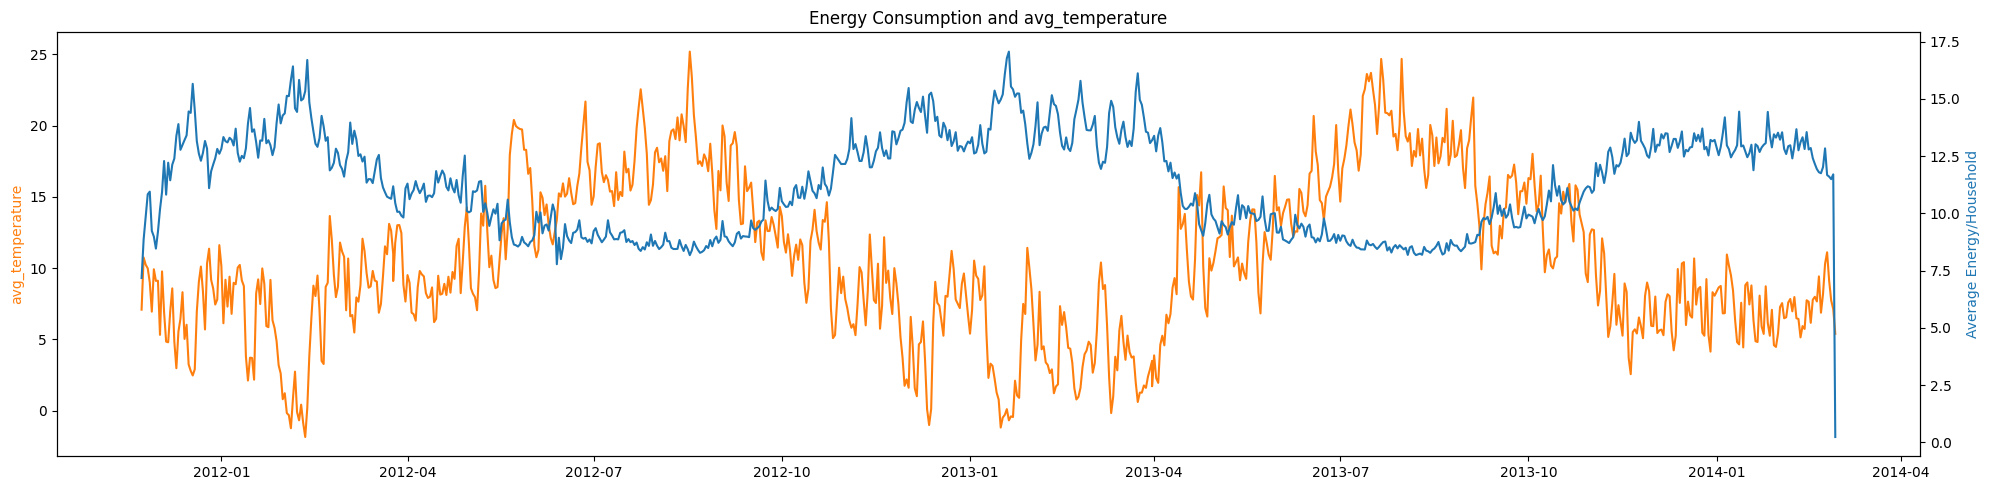

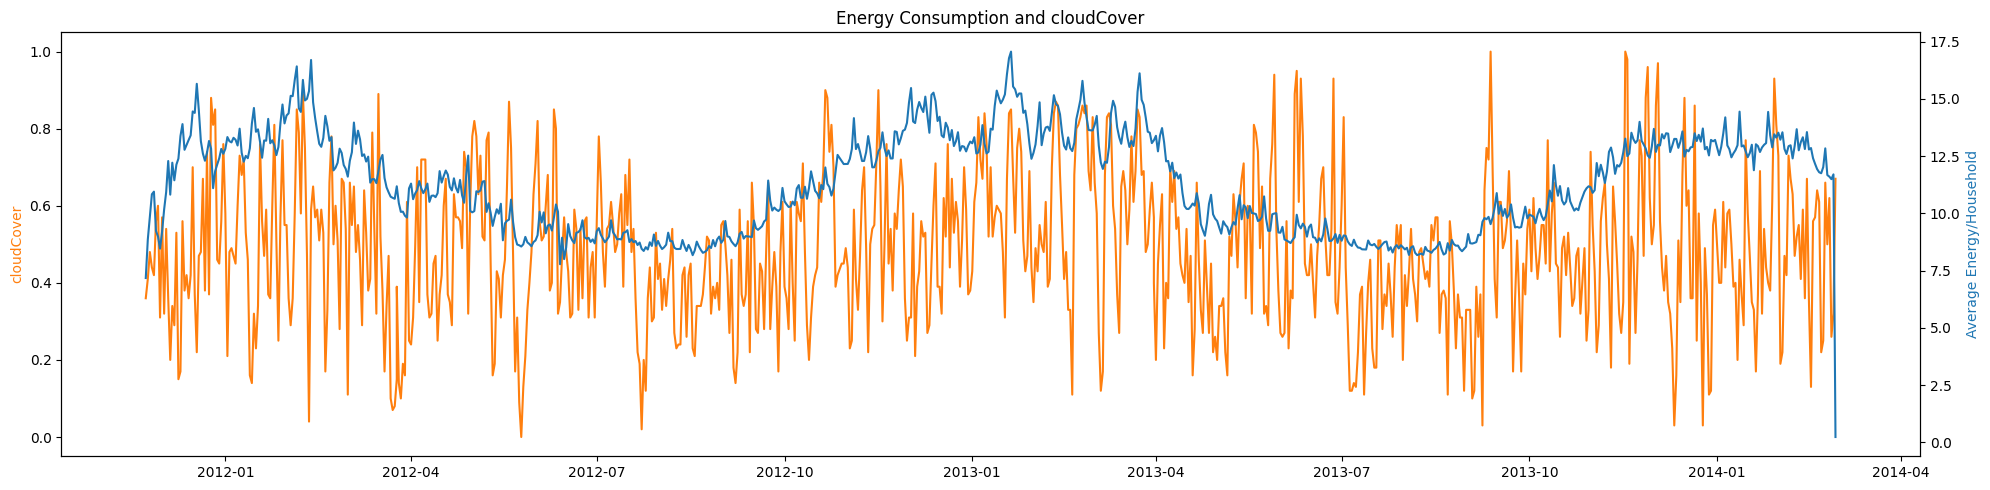

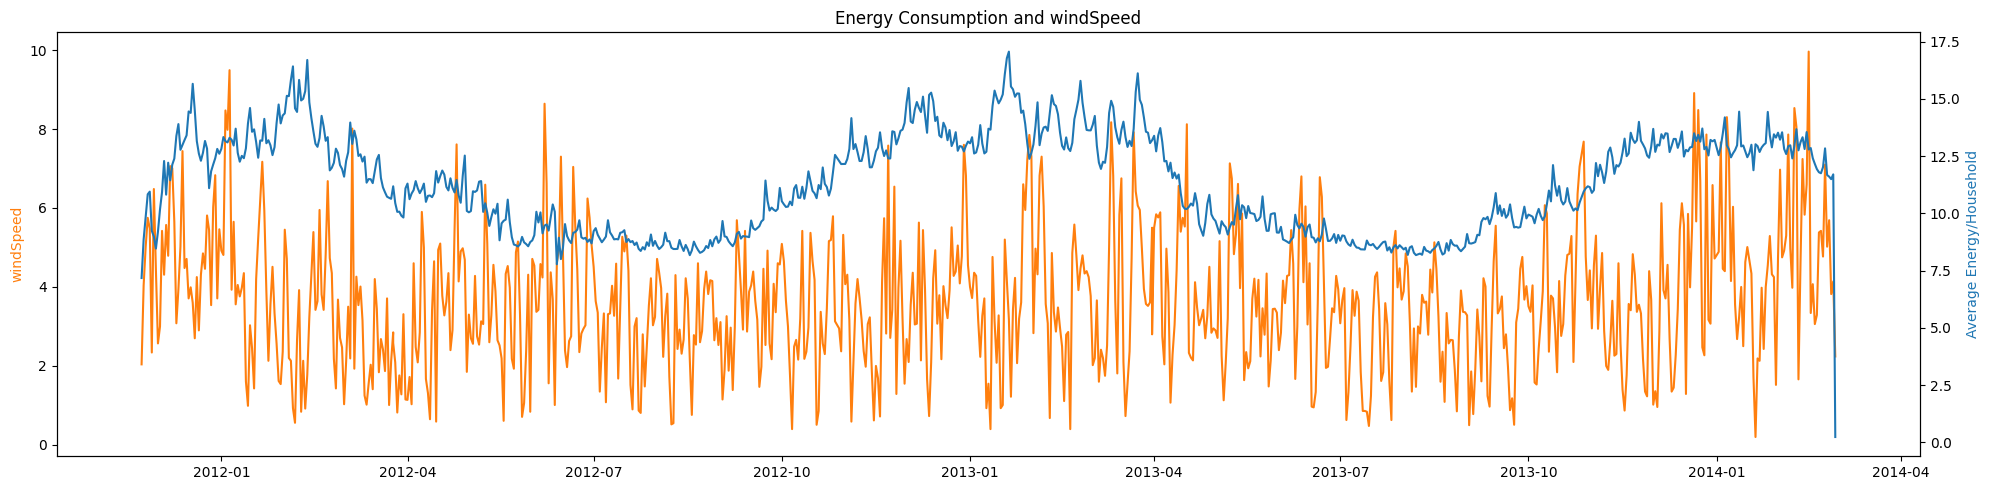

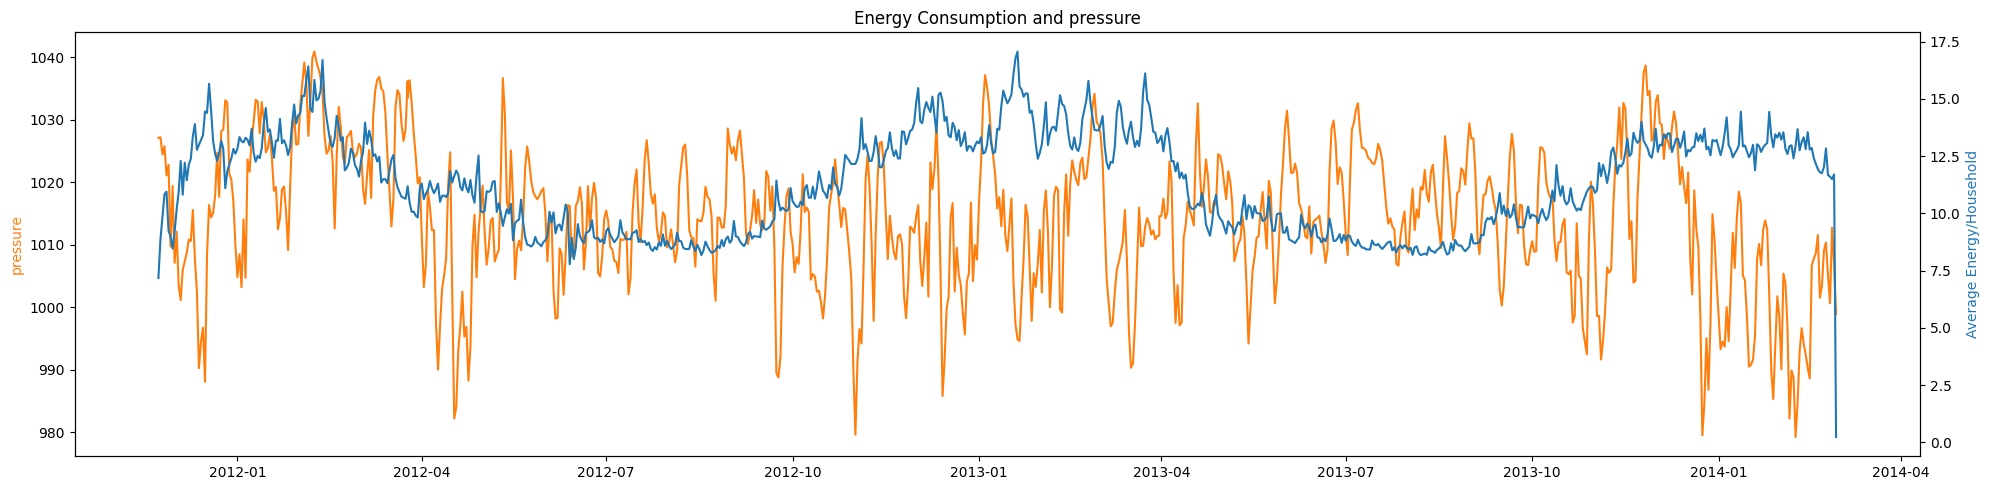

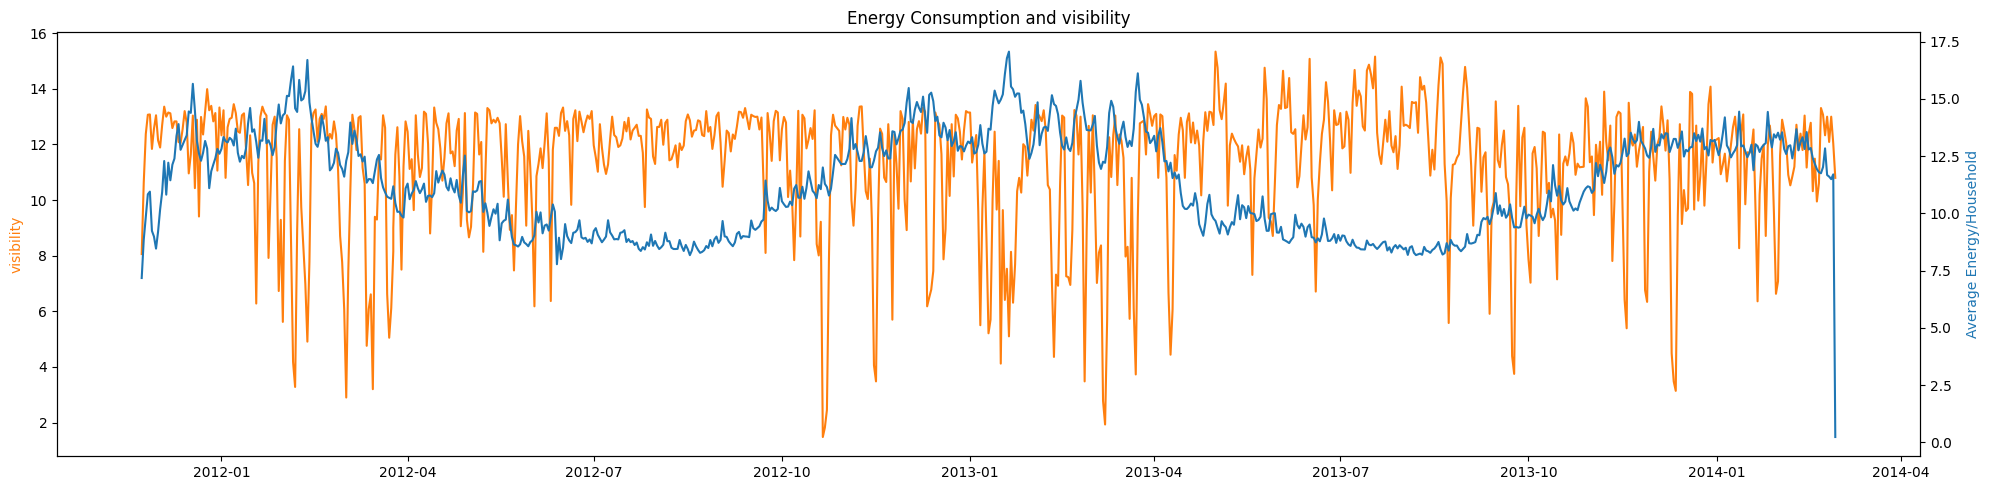

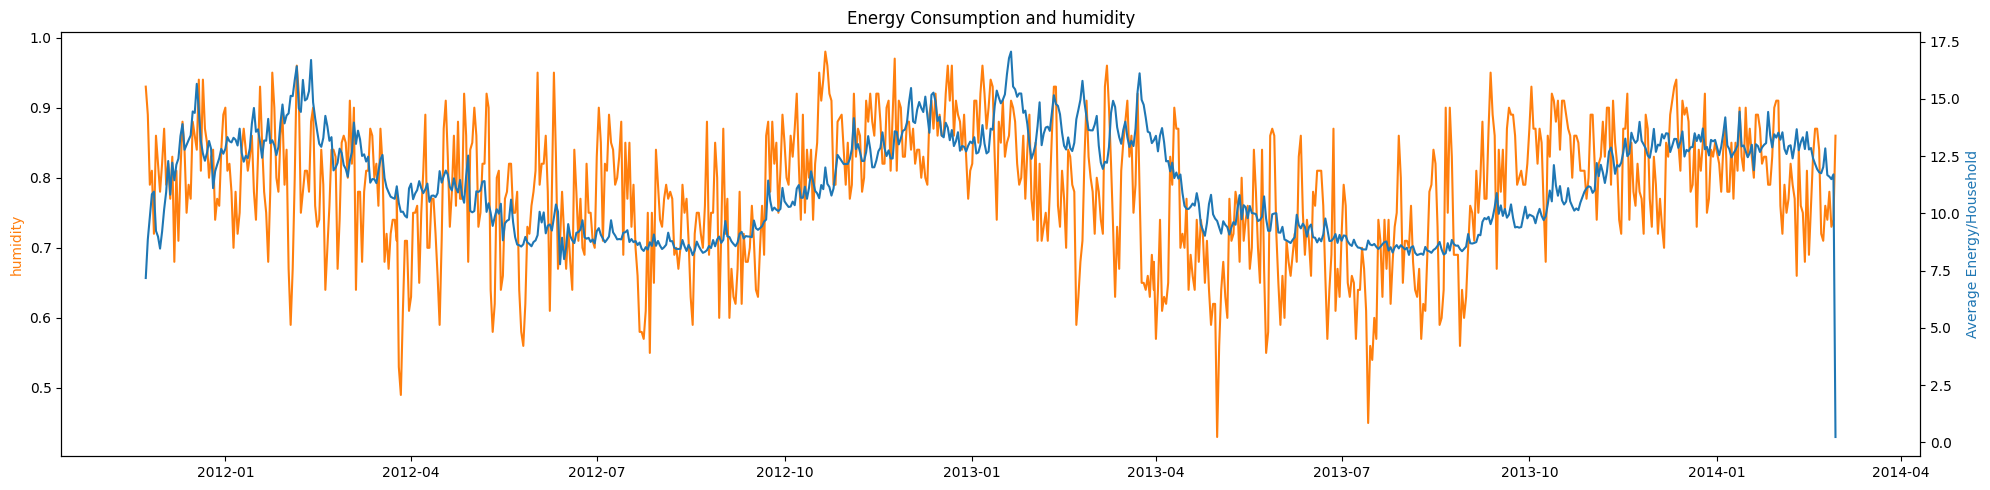

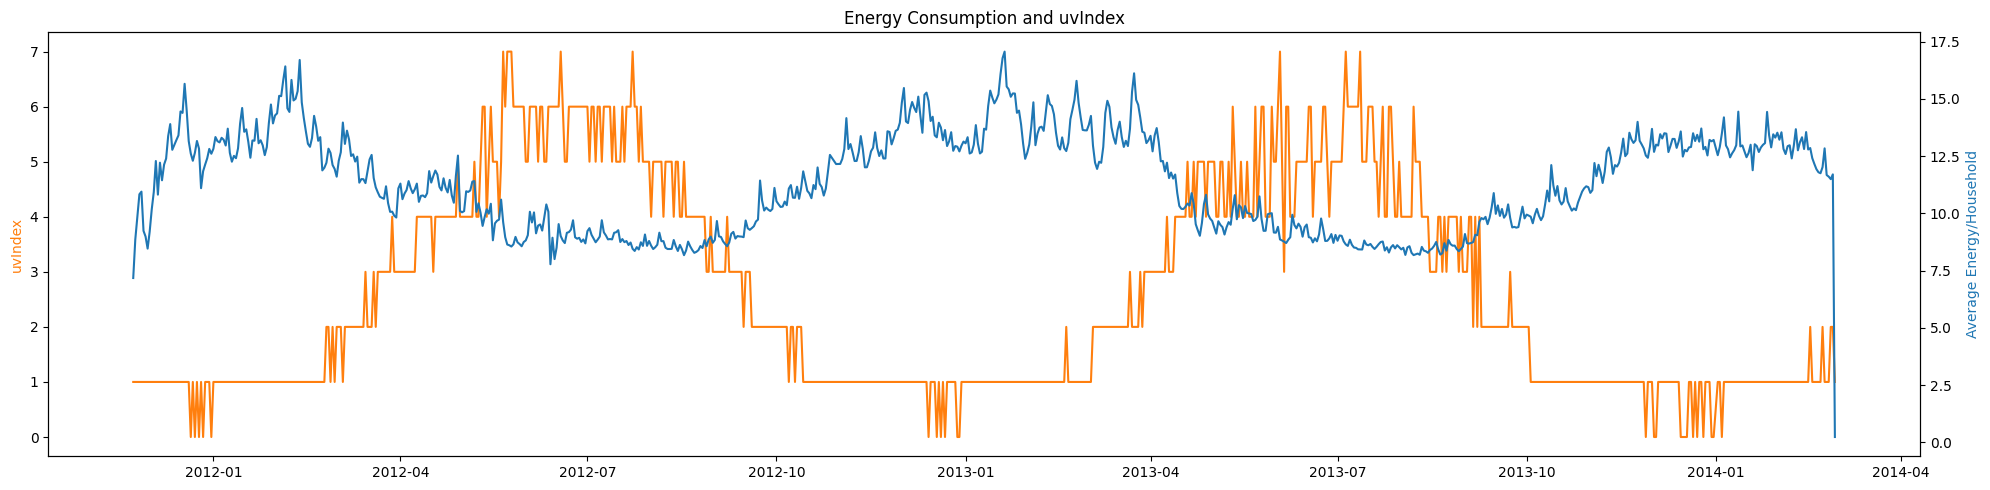

In [26]:
plot_energy_sum(weather_energy, columns_to_plot)

1. Temperature  
We can see that energy consumption and temperature have an inverse relationship — peaks on one side coincide with troughs on the other. This confirms the business understanding that during colder weather, energy consumption (through heating, etc.) tends to increase.  

2. Humidity  
Humidity and average energy consumption seem to follow the same trend.  

3. Cloud Cover  
Cloud cover values appear to follow a similar pattern to energy consumption.  

4. Visibility  
The visibility factor does not seem to affect energy consumption at all — since visibility is likely an external factor, its increase or decrease probably doesn’t impact household energy usage.  

5. Wind Speed  
Like visibility, wind speed appears to be an external factor that does not significantly influence energy consumption.  

6. UV  
The UV index has an inverse relationship with energy consumption.  

7. Dew Point  
As a function of humidity and temperature, it shows a similar relationship with energy consumption.

### Correlation between weather variables and energy consumption
* Energy shows a strong positive correlation with humidity and a strong negative correlation with temperature.  
* Dew point and UV index are highly correlated with temperature, so they were removed.  
* Cloud cover and visibility are highly correlated with humidity, so they were also removed.

In [27]:
heatmap_cols = ['avg_energy','temperatureMax','dewPoint', 'cloudCover', 'windSpeed',
                'pressure', 'visibility', 'humidity','uvIndex', 'moonPhase','avg_temperature']

In [28]:
def plot_heat_map(dataframe, columns):
    cor_matrix = dataframe[columns].corr()
    plt.figure(figsize=(14, 10))
    sns.heatmap(cor_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.show()

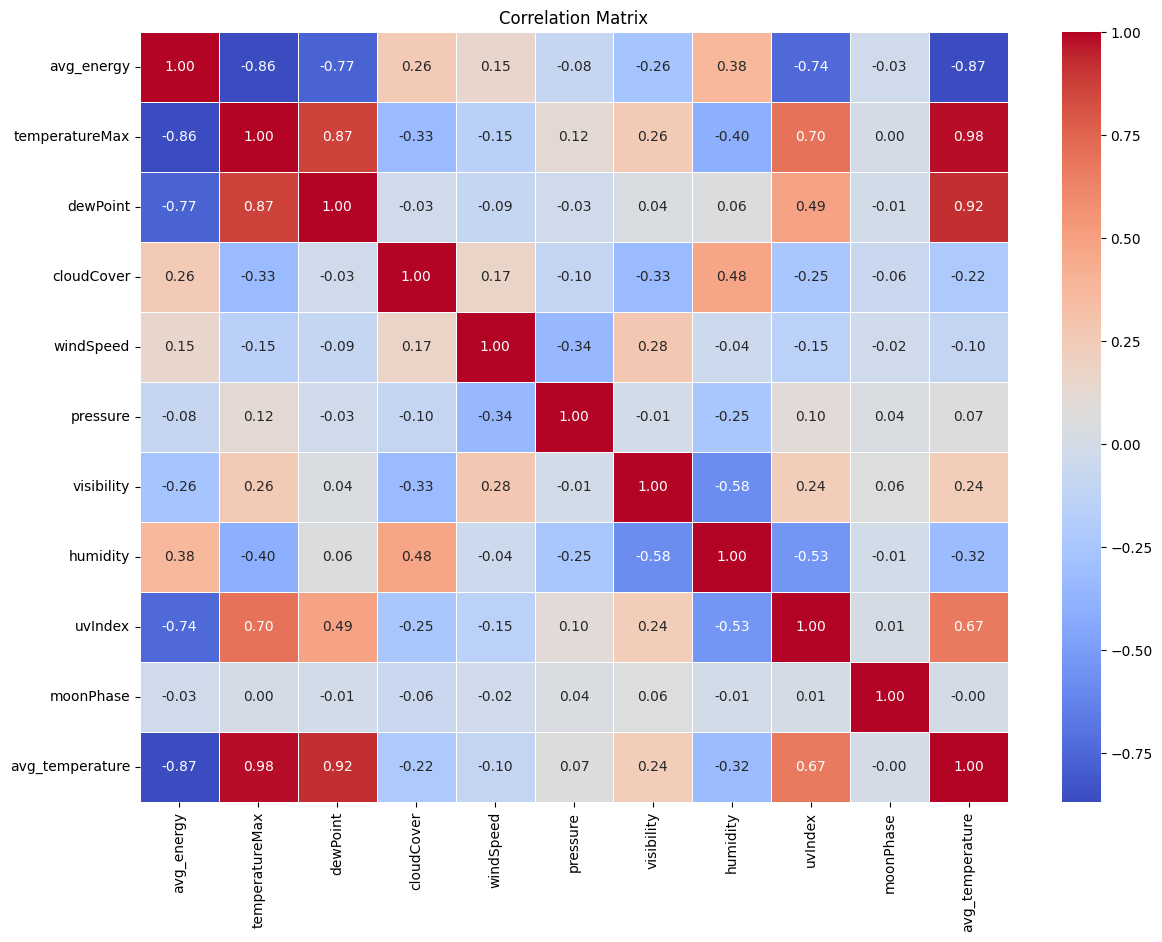

In [29]:
plot_heat_map(weather_energy, heatmap_cols)

## UK Holidays

In [30]:
holiday = pd.read_csv(f'{path}/uk_bank_holidays.csv')
holiday['Bank holidays'] = pd.to_datetime(holiday['Bank holidays'],format='%Y-%m-%d').dt.date
holiday.head(4)

,Bank holidays,Type
0,2012-12-26,Boxing Day
1,2012-12-25,Christmas Day
2,2012-08-27,Summer bank holiday
3,2012-05-06,Queen?s Diamond Jubilee (extra bank holiday)


In [31]:
holiday['Bank holidays'] = pd.to_datetime(holiday['Bank holidays'])

**Creating a holiday indicator on weather data**

In [32]:
weather_energy = weather_energy.merge(holiday, left_on = 'day',right_on = 'Bank holidays',how = 'left')
weather_energy['holiday_ind'] = np.where(weather_energy['Bank holidays'].isna(),0,1)

## Seasonal Decomposition

The seasonal component is relatively weak, while the trend component is quite strong — showing a clear decrease in electricity consumption during the summer months (from April to September). This may be due to longer daylight hours in summer.


In [33]:
cols_2_plot = ['avg_energy', 'avg_temperature']

In [34]:
def plot_seasonal_decomposition(df, cols_2_plot):
    for col in cols_2_plot:
        print('col:',col)
        decomposed_result = sm.tsa.seasonal_decompose(df[col], period = 30)
        figure = decomposed_result.plot()
    plt.tight_layout()
    plt.show()

col: avg_energy
col: avg_temperature


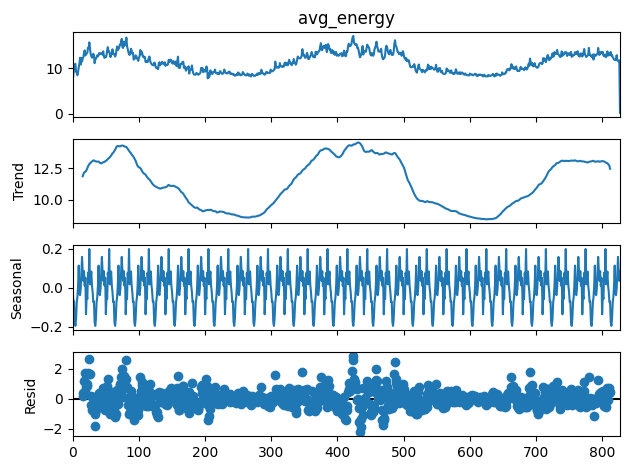

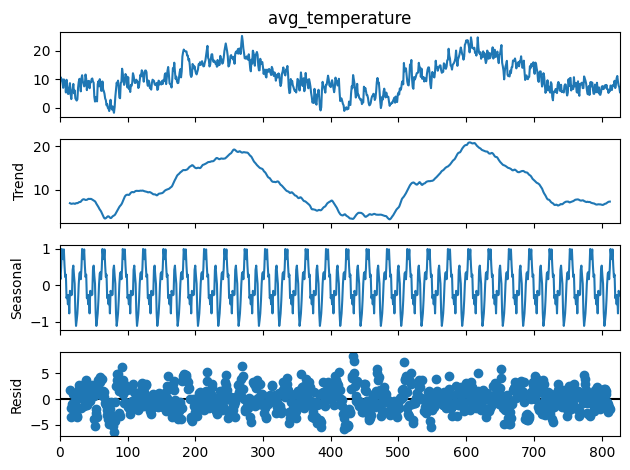

In [35]:
plot_seasonal_decomposition(weather_energy, cols_2_plot)

# TRAIN MODEL

We will train models to predict the **`avg_energy`** label and forecast multiple steps into the future.


## Preprocessing


In [36]:
df = weather_energy.copy()
df = df.fillna(0)


In [37]:
df.drop(columns=['Type', 'Bank holidays', 'year', 'month', 'weekday'], inplace=True)

In [38]:
df.head()

,day,energy_sum,LCLid,avg_energy,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,...,apparentTemperatureLow,apparentTemperatureMax,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase,avg_temperature,holiday_ind
0,2011-11-23,78.968000,11,7.178909,10.36,229,6.29,0.36,2.04,1027.12,...,6.56,10.36,1.0,8.24,3.81,10.36,2.18,0.94,7.085,0
1,2011-11-24,177.228000,20,8.861400,12.93,204,8.56,0.41,4.04,1027.22,...,7.30,12.93,1.0,9.71,8.56,12.93,7.01,0.97,10.745,0
2,2011-11-25,246.590000,25,9.863600,13.03,243,7.24,0.48,5.02,1024.47,...,4.69,13.03,1.0,7.01,7.46,12.27,4.84,0.01,10.245,0
3,2011-11-26,357.634000,33,10.837394,12.96,237,6.96,0.44,5.75,1025.80,...,11.59,12.96,1.0,11.59,7.01,12.96,4.69,0.05,9.985,0
4,2011-11-27,361.435001,33,10.952576,13.54,256,5.76,0.42,5.48,1021.11,...,1.31,13.54,1.0,1.31,4.47,13.54,2.94,0.08,9.005,0


### Time feature

Create more time data using sin cos function

In [39]:
#Enable the Date index of yfinance data
df.reset_index(drop=True, inplace=True)
#Extract date
date_time = pd.to_datetime(df.pop('day'))

In [40]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

week = 7*24*60*60
month = 30*24*60*60
year = (12)*month

df['week sin'] = np.sin(timestamp_s * (2 * np.pi / week))
df['week cos'] = np.cos(timestamp_s * (2 * np.pi / week))
df['month sin'] = np.sin(timestamp_s * (2 * np.pi / month))
df['month cos'] = np.cos(timestamp_s * (2 * np.pi / month))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

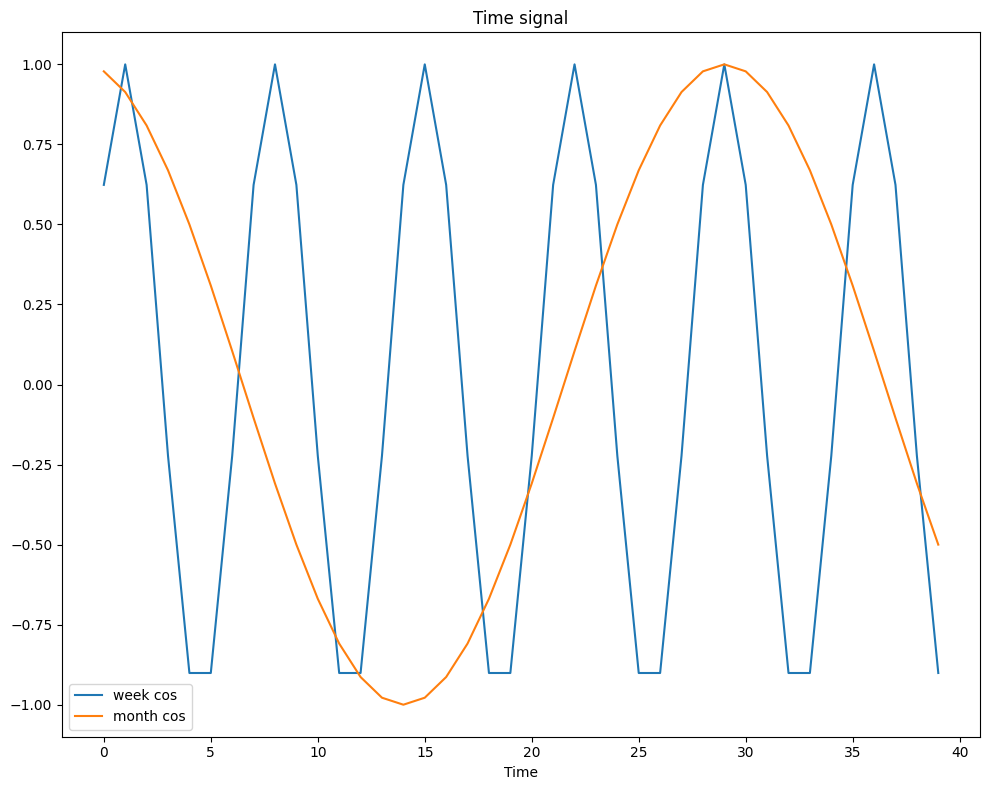

In [41]:
plt.figure(figsize=(10, 8))

plt.plot(np.array(df['week cos'][:40]), label ='week cos')
plt.plot(np.array(df['month cos'][:40]), label = 'month cos')
plt.legend()
plt.xlabel('Time')
plt.title('Time signal')

plt.tight_layout()

In [42]:
cat_cols = ['holiday_ind', 'LCLid']
num_cols = [element for element in df.columns if (element not in cat_cols)]

### Data Scaling

Scale the continuous values using Standard Scaler

In [43]:
Numerical = Pipeline(steps=[('standard scaler',StandardScaler())])

In [44]:
def dataframe_pipe_trans(dataframe, num_cols = num_cols):
    # Standardize pipe
    Numerical.fit(dataframe[num_cols])
    Numerical_df = pd.DataFrame(Numerical.transform(dataframe[num_cols]), columns=num_cols)

    # Combine standardized and log transformed columns
    transformed_df = Numerical_df.copy()
    transformed_df.reset_index(drop=True, inplace=True)

    return transformed_df
df = dataframe_pipe_trans(df)
df.head()

,energy_sum,avg_energy,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,apparentTemperatureHigh,visibility,...,temperatureHigh,apparentTemperatureMin,moonPhase,avg_temperature,week sin,week cos,month sin,month cos,Year sin,Year cos
0,-2.156099,-1.942363,-0.524895,0.348533,-0.051751,-0.624887,-0.914644,1.176102,-0.314016,-1.396039,...,-0.499423,-0.581541,1.522901,-0.632230,-1.107533,0.878566,0.279949,1.385804,0.107765,-1.350746
1,-2.148098,-1.151546,-0.118988,0.067830,0.409895,-0.363729,0.256526,1.185108,0.030500,-0.283827,...,-0.098540,0.200896,1.627064,0.031974,-0.001336,1.410784,0.561601,1.294584,0.083176,-1.350089
2,-2.142449,-0.680484,-0.103194,0.505727,0.141449,0.001892,0.830399,0.937461,-0.057975,0.466269,...,-0.201491,-0.150634,-1.706151,-0.058764,1.104861,0.878566,0.818072,1.146989,0.058602,-1.348995
3,-2.133407,-0.222774,-0.114249,0.438358,0.084506,-0.207034,1.257875,1.057232,0.034522,0.763721,...,-0.093861,-0.174933,-1.567267,-0.105948,1.378069,-0.317317,1.038153,0.949467,0.034051,-1.347464
4,-2.133098,-0.168636,-0.022644,0.651692,-0.159536,-0.311497,1.099767,0.634881,0.112273,0.768032,...,-0.003389,-0.458425,-1.463104,-0.283795,0.612557,-1.276341,1.212224,0.710651,0.009530,-1.345495


### Train/test split

Here we split the train/valid/test with ratio 70/20/10

In [45]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]
print ('len(train_df)',len(train_df))

len(train_df) 579


## Create window

This window helps create input and label "windows" from time series data for machine learning models, especially for tasks like forecasting.

* **Label Management:**

  * Can handle specific target columns (`label_columns`) for prediction.
  * Creates a mapping of label column names to their indices for easy access.
  * Also stores a mapping of all column names to their indices.

* **Window Parameters:**

  * `input_width`: number of past time steps used as input.
  * `label_width`: number of future time steps to predict.
  * `shift`: how far in the future the label window starts relative to the input window.
  * Calculates `total_window_size = input_width + shift`.

* **Slicing for Windowing:**

  * `input_slice` and `input_indices`: identify the range of indices used as input.
  * `labels_slice` and `label_indices`: identify the range of indices used as output labels.


In [46]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

We do a sample for this window here

In [47]:
OUT_STEPS = 10 # Số bước dự đoán trong tương lai
input_width =20 # Số bước input
multi_window = WindowGenerator(input_width=input_width,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,label_columns = ['avg_energy'])
multi_window

Total window size: 30
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Label indices: [20 21 22 23 24 25 26 27 28 29]
Label column name(s): ['avg_energy']

In [48]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [49]:
# Example for split window
example_window = tf.stack([np.array(train_df[:multi_window.total_window_size]),
                           np.array(train_df[100:100+multi_window.total_window_size]),
                           np.array(train_df[200:200+multi_window.total_window_size])])

example_inputs, example_labels = multi_window.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 30, 26)
Inputs shape: (3, 20, 26)
Labels shape: (3, 10, 1)


## Plot

Here we create a function to plot data

In [50]:
def plot(self, model=None, plot_col='avg_energy', max_subplots=3):

    inputs, labels = self.split_window(example_window)
    plt.figure(figsize=(20, 10))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))

    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [day]')

WindowGenerator.plot = plot

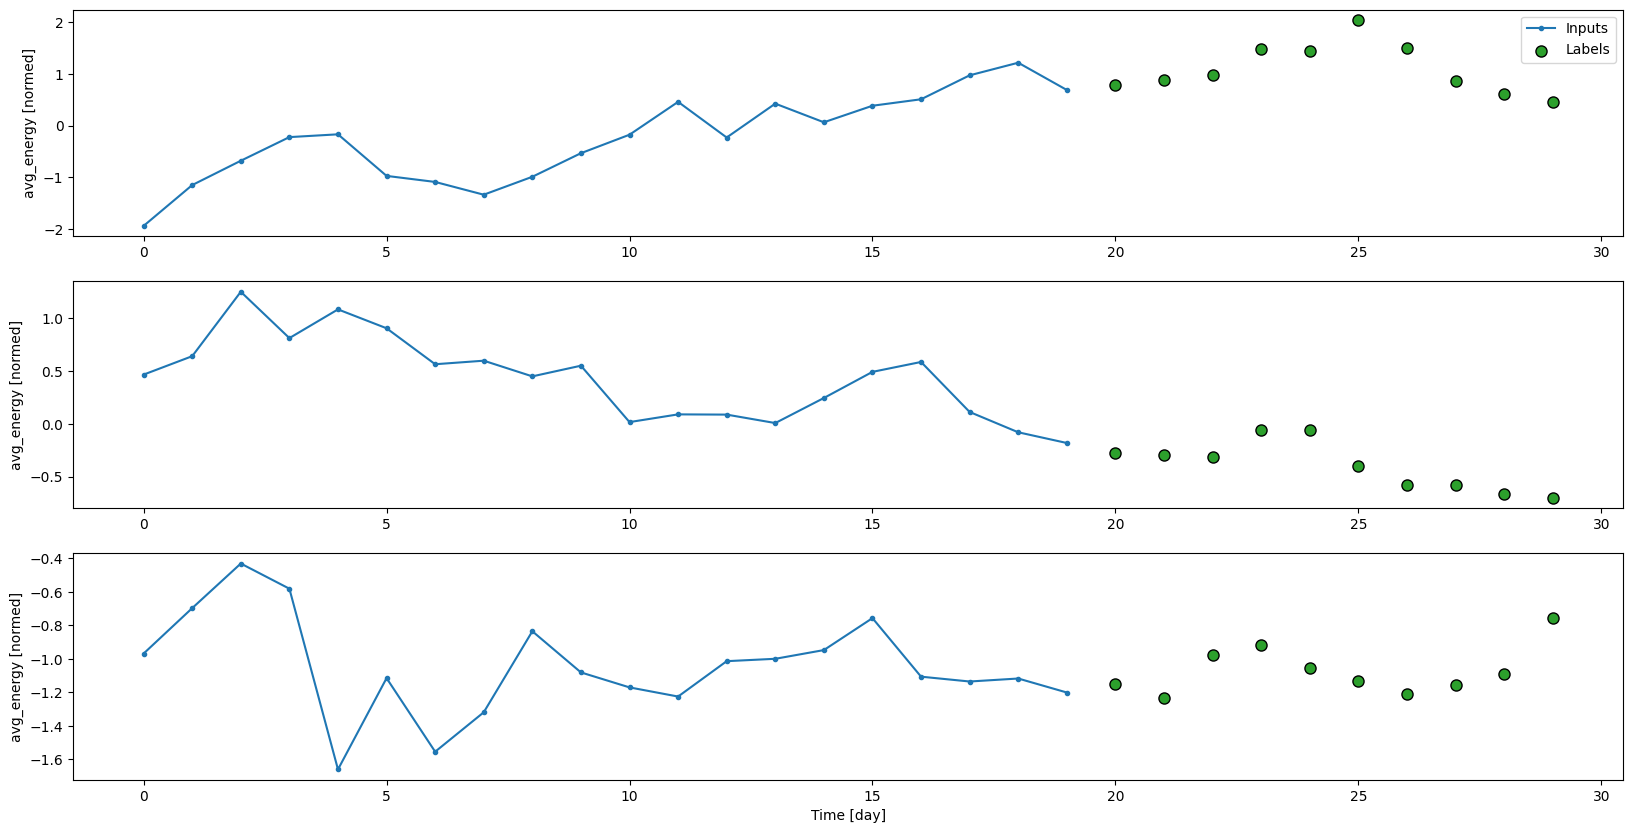

In [51]:
multi_window.plot()

## Create dataset

Here we use our window class slide through our data to create train/test/validation dataset

In [52]:
def make_dataset(self, data): #data lấy liên tục
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,#to avoid sequence bias
      batch_size=64,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [53]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [54]:
for inputs, labels in multi_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {inputs.shape}')
    print(f'Labels shape (batch, time, features): {labels.shape}')

Inputs shape (batch, time, features): (64, 20, 26)
Labels shape (batch, time, features): (64, 10, 1)


In [55]:
multi_window.train

<_MapDataset element_spec=(TensorSpec(shape=(None, 20, 26), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10, 1), dtype=tf.float32, name=None))>

# Build and train model

Here, two additional techniques are used: **learning rate schedule** and **early stopping**.

1. **Learning Rate Schedule:**
   The Learning Rate Schedule technique is used to adjust the learning rate of a machine learning model over time or according to certain criteria. The main goal is to reduce the learning rate as the model progresses through training iterations. This can help the model converge faster and more efficiently. There are various strategies, such as step decay, exponential decay, and piecewise constant decay.

2. **Early Stopping:**
   Early Stopping is a technique used to stop the training process earlier when there is no longer improvement in accuracy on the validation set. Instead of continuing training until the validation accuracy drops, early stopping helps prevent overfitting by halting when the model has “overlearned” from the training data. This reduces the risk of the model becoming too complex and failing to generalize well to new data.


In [56]:
tf.keras.backend.clear_session()
MAX_EPOCHS = 200

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))

def compile_and_fit(model, window, patience=20):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
    # Set the learning rate scheduler
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)


    model.compile(loss=tf.keras.losses.Huber(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError(),
                         tf.keras.metrics.RootMeanSquaredError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[lr_schedule, early_stopping],verbose=1)
    return history

In [57]:
def plot_train (history):
    # list all data in history
    print(history.history.keys())

    # summarize history for loss

    fig, ax = plt.subplots()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

## **LSTM Model**

The LSTM model is a type of recurrent neural network (RNN) designed to handle sequential data. LSTMs can retain information from previous time steps in a sequence and use this information to predict future values.

In time series forecasting, the LSTM model can be used to learn the relationships between values in the sequence. For example, rainfall data can be used to predict future rainfall, and the LSTM model can learn the relationships between past rainfall values to make accurate predictions.


In [58]:
val_performance = {}
performance = {}

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0426 - mean_absolute_error: 0.2255 - root_mean_squared_error: 0.2917
dict_keys(['loss', 'mean_absolute_error', 'root_mean_squared_error', 'val_loss', 'val_mean_absolute_error', 'val_root_mean_squared_error', 'learning_rate'])


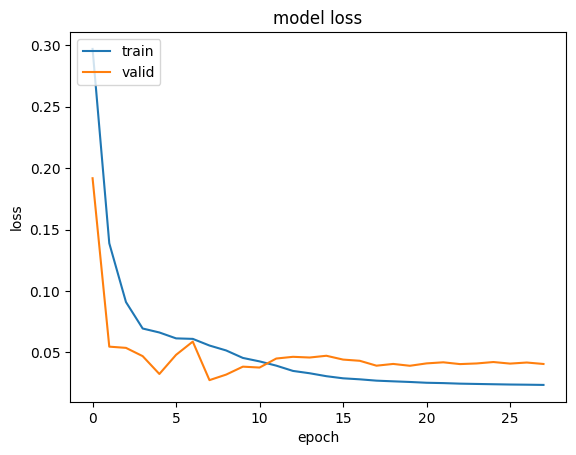

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 1024)       │     4,304,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1024)           │     8,392,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 260)            │        66,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 10, 26)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,261,646 (153.59 MB)

 Trainable params: 13,420,548 (51.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 26,841,098 (102.39 MB)

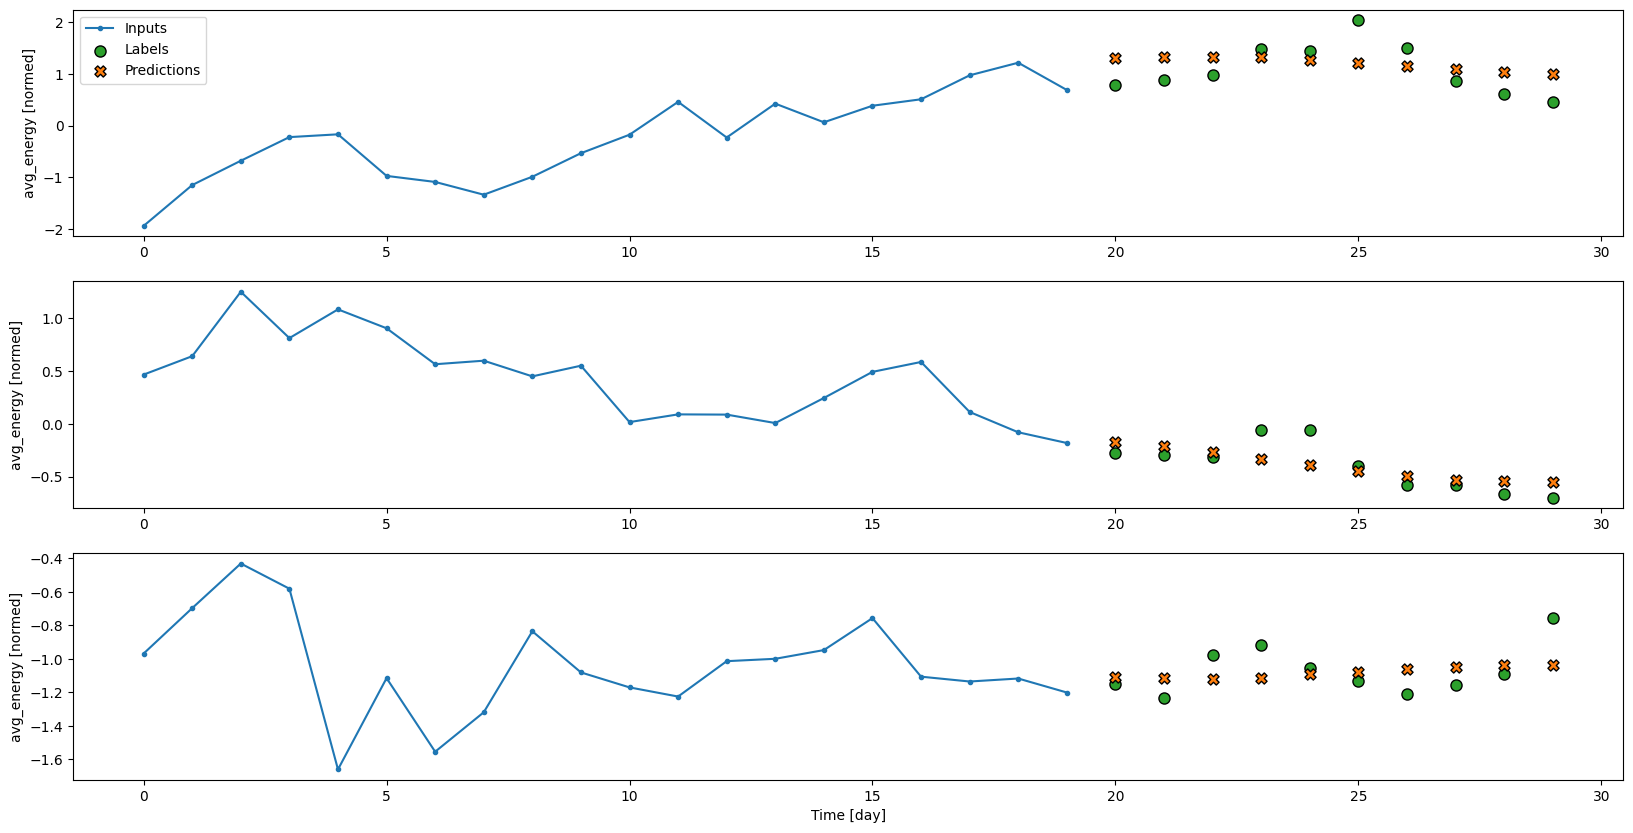

In [59]:
lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(1024, return_sequences=True),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.LSTM(1024, return_sequences=False),

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256),

    tf.keras.layers.Dense(OUT_STEPS * num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

# Train LSTM
history_lstm = compile_and_fit(lstm_model, multi_window)
IPython.display.clear_output()

# Evaluate LSTM
val_performance['LSTM'] = lstm_model.evaluate(multi_window.val)
performance['LSTM'] = lstm_model.evaluate(multi_window.test, verbose=0)

# Plot LSTM training
plot_train(history_lstm)
multi_window.plot(lstm_model)
lstm_model.summary()

## Bidirectional LSTM (Bi-LSTM)  

A **Bidirectional LSTM (Bi-LSTM)** is an extension of the standard LSTM network that can improve learning from sequential data by processing it in both forward and backward directions.  

### How Bi-LSTM Works
- In a standard LSTM, the model processes the sequence **from past to future** (forward direction).  
- A Bi-LSTM consists of **two LSTM layers**:  
  1. **Forward LSTM:** Processes the input sequence in its natural order.  
  2. **Backward LSTM:** Processes the input sequence in reverse order.  
- The outputs of both LSTMs are then **combined** (usually concatenated) at each time step before passing to the next layer or the output.  

### Advantages of Bi-LSTM
- Can capture **past and future context** simultaneously.  
- Particularly useful when the prediction depends on both previous and later elements in the sequence.  
- Often improves performance in tasks like **time series forecasting, natural language processing, and speech recognition**.  


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0398 - mean_absolute_error: 0.2143 - root_mean_squared_error: 0.2820
dict_keys(['loss', 'mean_absolute_error', 'root_mean_squared_error', 'val_loss', 'val_mean_absolute_error', 'val_root_mean_squared_error', 'learning_rate'])


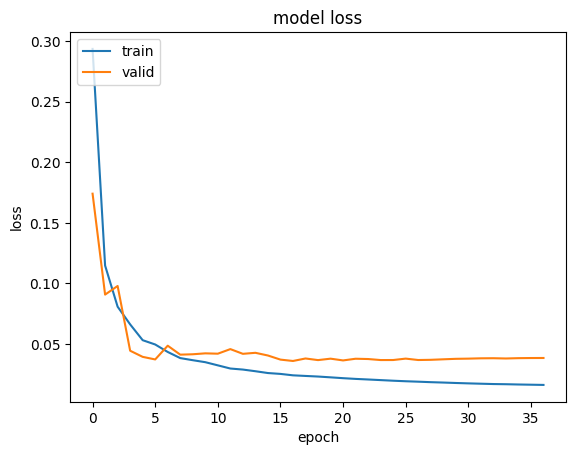

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 20, 2048)       │     8,609,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 2048)           │    25,174,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 260)            │        66,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 10, 26)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 105,093,134 (400.90 MB)

 Trainable params: 35,031,044 (133.63 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 70,062,090 (267.27 MB)

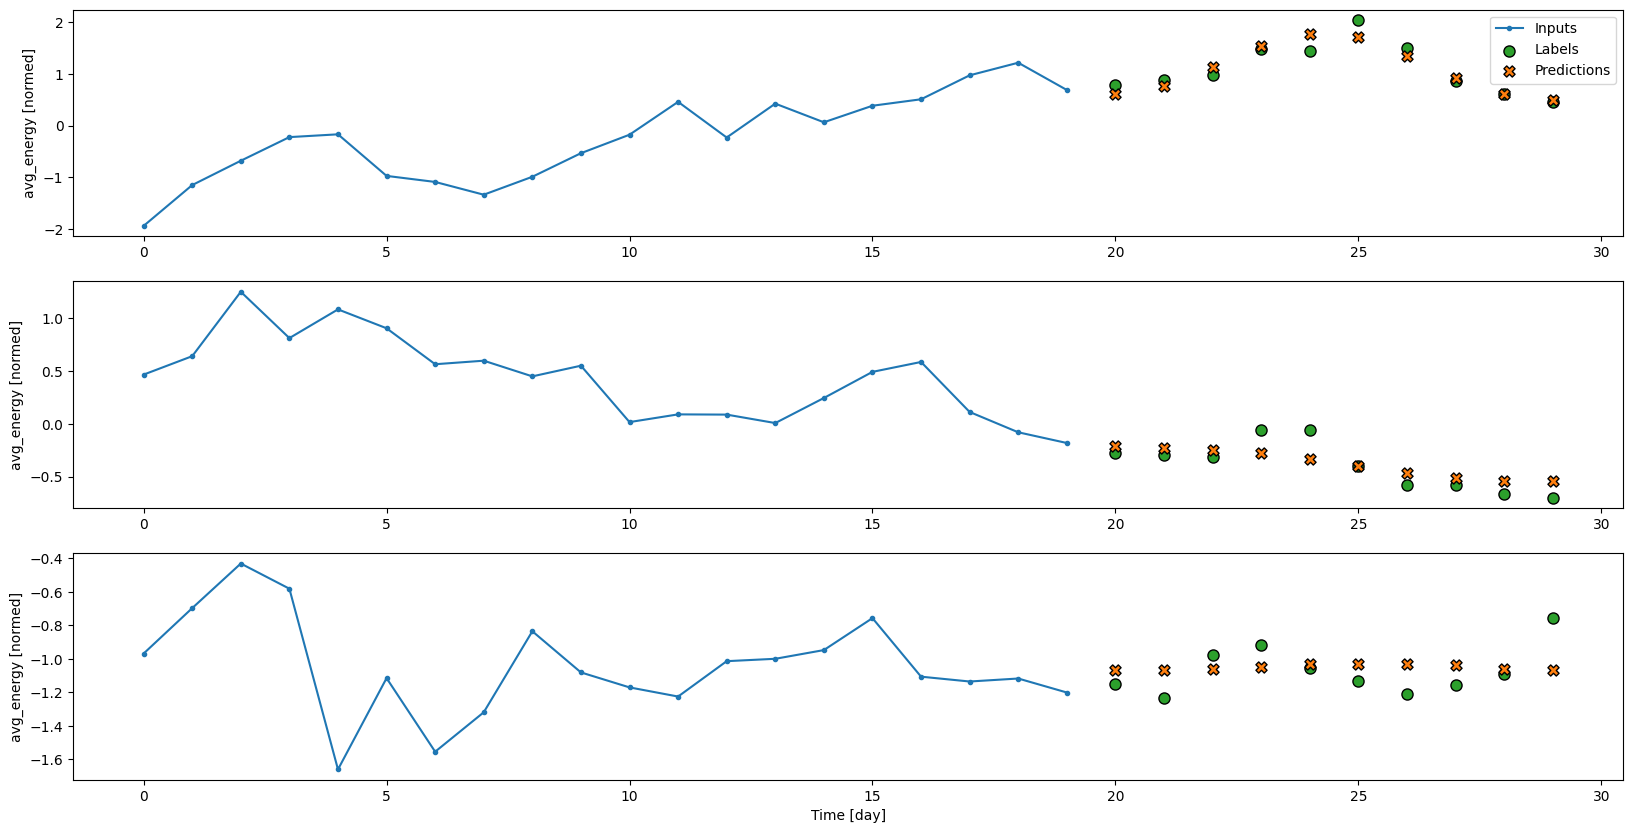

In [60]:
bi_lstm_model = tf.keras.Sequential([
    # Bidirectional LSTM layers
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1024, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1024, return_sequences=False)),

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256),

    tf.keras.layers.Dense(OUT_STEPS * num_features,
                          kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

# Train Bi-LSTM
history_bi_lstm = compile_and_fit(bi_lstm_model, multi_window)
IPython.display.clear_output()

# Evaluate Bi-LSTM
val_performance['Bi-LSTM'] = bi_lstm_model.evaluate(multi_window.val)
performance['Bi-LSTM'] = bi_lstm_model.evaluate(multi_window.test, verbose=0)

# Plot Bi-LSTM training
plot_train(history_bi_lstm)
multi_window.plot(bi_lstm_model)
bi_lstm_model.summary()

## Compare Results

LSTM - compile_metrics: Validation = 0.2195, Test = 0.3229
Bi-LSTM - compile_metrics: Validation = 0.2107, Test = 0.3503


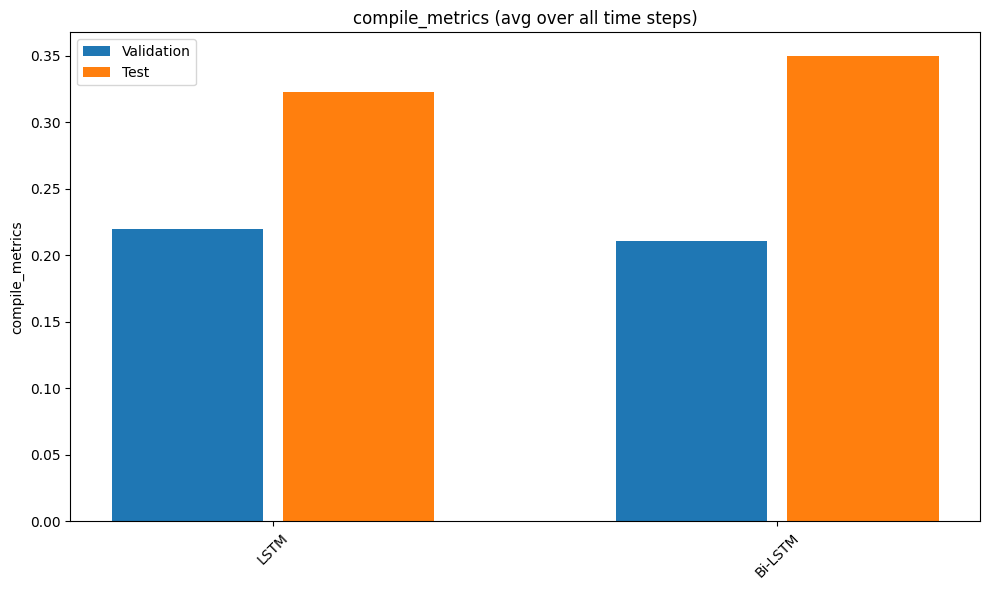

In [61]:
x = np.arange(len(performance))
width = 0.3

plt.figure(figsize=(10, 6))
plt.subplots_adjust(top=1.1, bottom=0.2)

# Use metrics from one of the models (they should be the same)
metric_name = lstm_model.metrics_names[1:]  # skip loss

for i, name in enumerate(metric_name, 1):
    plt.subplot(1, len(metric_name), i)

    metric_index = lstm_model.metrics_names.index(name)
    val_values = [v[metric_index] for v in val_performance.values()]
    test_values = [v[metric_index] for v in performance.values()]

    # Print values
    for model_name, val, test in zip(performance.keys(), val_values, test_values):
        print(f"{model_name} - {name}: Validation = {val:.4f}, Test = {test:.4f}")

    plt.bar(x - 0.17, val_values, width, label='Validation')
    plt.bar(x + 0.17, test_values, width, label='Test')
    plt.title(f'{name} (avg over all time steps)')
    plt.xticks(ticks=x, labels=performance.keys(), rotation=45)
    plt.ylabel(f'{name}')
    plt.legend()

plt.tight_layout()
plt.show()


* **LSTM vs Bi-LSTM:**

  * The Bi-LSTM has **higher validation and test errors** than the standard LSTM in this case.
  * This could indicate that for this dataset, **Bi-LSTM is overfitting** slightly due to more parameters, or the additional backward context is not significantly helpful.

* **Takeaways:**

  * LSTM provides a more stable performance with lower error.
  * Bi-LSTM might be useful if your sequence has **strong dependencies in both directions**, but here one-direction LSTM seems sufficient.


# Summary

### EDA Key Insights

1. **Dataset Overview:** 2,000,000 records spanning over two years (Nov 2011 – Feb 2014), with average household energy consumption around 11 kWh/day, showing a right-skewed distribution with some high-consumption outliers.
2. **Household Variation:** Number of households with data varies daily, so average energy consumption per household is a more reliable metric than total energy.
3. **Seasonal and Weekly Patterns:** Energy consumption peaks in winter (Dec–Feb) and on weekends, with summer showing a clear decrease likely due to longer daylight hours.
4. **Temperature and Energy:** Strong negative correlation between temperature and energy usage; colder days drive higher consumption.
5. **Humidity and Cloud Cover:** Energy usage positively correlates with humidity and cloud cover, indicating weather-related heating demand.
6. **UV and Dew Point:** UV index inversely correlates with energy use, while dew point follows temperature and humidity patterns; visibility and wind speed have minimal impact.
7. **Correlation Analysis:** Temperature and humidity are the primary predictors, while dew point, UV index, cloud cover, and visibility were removed due to high correlation with other variables.


### Training Results

* **LSTM vs Bi-LSTM:**

  * LSTM achieved lower validation and test errors.
  * Bi-LSTM shows higher errors, suggesting slight overfitting or limited benefit from backward context in this dataset.
* **Conclusion:** One-directional LSTM is sufficient for predicting daily average energy consumption.

### Potential Improvements

1. **Feature Engineering:** Incorporate additional weather features (e.g., heating degree days, holidays, or household-level attributes) to improve prediction accuracy.
2. **Data Normalization/Scaling:** Ensure input features are properly scaled to improve LSTM training stability.
3. **Regularization:** Apply dropout or L2 regularization in Bi-LSTM to reduce overfitting.
4. **Hyperparameter Tuning:** Experiment with sequence length, learning rate, and hidden layer size for better performance.
5. **External Factors:** Include calendar effects (holidays, special events) or socioeconomic factors to capture variations beyond weather.
6. **Advanced Models:** Test hybrid models (e.g., LSTM + attention) or Transformer-based time series models if long-term dependencies are important.

